In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from Models import STDP_module
import chainer
import os
from tqdm import tqdm

2024-02-21 17:59:47.443866: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-21 17:59:47.474347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/bdr/anaconda3/envs/deep/lib/python3.11/site-packages/cupy/_environment.py:444: UserWarning: 
nccl library could not be loaded.

Reason: ImportError (libnccl.so.2: cannot open shared object file: No such file or directory)

You can install the library by:
  $ conda install -c conda-forge nccl

  warnings.warn(f'''
/home/bdr/anaconda3/envs/deep/lib/p

0


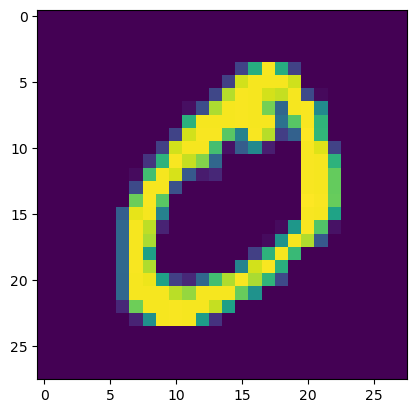

In [2]:
train,_=chainer.datasets.get_mnist()
plt.imshow(np.reshape(train[1][0],(28,28)))
print(train[1][1])

11973 5421


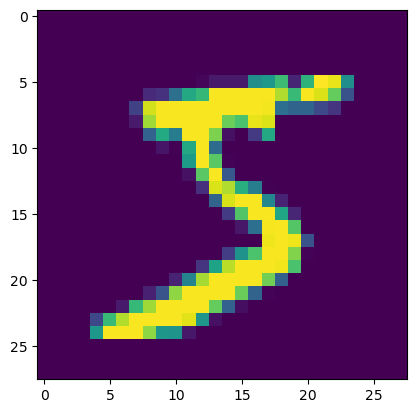

In [3]:
dataset_3_4=[]
dataset_5=[]
for data in train:
    if data[1]== 3 or data[1]==4:
        dataset_3_4.append(data)

for data in train:
    if data[1]==5:
        dataset_5.append(data)

print(len(dataset_3_4),len(dataset_5))

plt.imshow(np.reshape(dataset_3_4[0][0],(28,28)))
plt.imshow(np.reshape(dataset_5[0][0],(28,28)))

In [4]:
class Config:
    dt=1e-3#時間の刻み幅
    t_inj=0.350#実行させる時間
    t_blank=0.15#ブランクで何もしない時間
    nt_inj=round(t_inj/dt)
    nt_blank=round(t_blank/dt)

    n_neurons=100#興奮性抑圧性ニューロンの数
    n_labels=2
    n_epoch=15

    n_train=5000#学習に使うデータの数
    update_nt=nt_inj

    wexc=2.25
    winh=0.85

    result_save_dir='./LIF_WTA_STDP_MNIST_results/neurogenesis'
config=Config()
os.makedirs(config.result_save_dir,exist_ok=True)

#### とりあえず3と4の文字を入力することから始める

In [5]:
input_spikes=STDP_module.online_load_and_encoding_dataset(dataset=dataset_3_4,i=0,
                                        dt=config.dt,n_time=config.nt_inj)

labels=np.array([dataset_3_4[i][1] for i in range(len(dataset_3_4))])

network=STDP_module.Network(n_in=784,n_neurons=config.n_neurons,
                            wexc=config.wexc,winh=config.winh,
                            dt=config.dt,wmin=0.0,wmax=2e-5,
                            lr=(1e-2,1e-4),
                            update_nt=config.update_nt) 

network.initialize_states()

spikes=np.zeros((config.n_train,config.n_neurons)).astype(np.uint8)
accuracy_all=np.zeros(config.n_epoch)
blank_input=np.zeros(784)
init_max_fr=32

In [6]:
for epoch in range(config.n_epoch):
    for i in tqdm(range(config.n_train)):
        max_fr = init_max_fr
        while(True):
            spike_list = [] # サンプルごとにスパイクを記録するリスト
            # 画像刺激の入力
            for t in range(config.nt_inj):
                s_exc = network(input_spikes[t], stdp=True)
                spike_list.append(s_exc)
            
            spikes[i] = np.sum(np.array(spike_list), axis=0) # スパイク数を記録
            
            # ブランク刺激の入力
            for _ in range(config.nt_blank):
                _ = network(blank_input, stdp=False)

            num_spikes_exc = np.sum(np.array(spike_list)) # スパイク数を計算
            if num_spikes_exc >= 5: # スパイク数が5より大きければ次のサンプルへ
                break
            else: # スパイク数が5より小さければ入力発火率を上げて再度刺激
                max_fr += 16
    
    # ニューロンを各ラベルに割り当てる
    if epoch == 0:
        assignments, proportions, rates = STDP_module.assign_labels(spikes, labels,
                                                        config.n_labels)
    else:
        assignments, proportions, rates = STDP_module.assign_labels(spikes, labels,
                                                        config.n_labels, rates)
    print("Assignments:\n", assignments)
    
    # スパイク数の確認(正常に発火しているか確認)
    sum_nspikes = np.sum(spikes, axis=1)
    mean_nspikes = np.mean(sum_nspikes).astype(np.float16)
    print("Ave. spikes:", mean_nspikes)
    print("Min. spikes:", sum_nspikes.min())
    print("Max. spikes:", sum_nspikes.max())

    # 入力サンプルのラベルを予測する
    predicted_labels = STDP_module.prediction(spikes, assignments, config.n_labels)
    
    # 訓練精度を計算
    accuracy = np.mean(np.where(labels==predicted_labels, 1, 0)).astype(np.float16)
    print("epoch :", epoch, " accuracy :", accuracy)
    accuracy_all[epoch] = accuracy
    
    # 学習率の減衰
    network.lr_p *= 0.75
    network.lr_m *= 0.75
    
    # 重みの保存(エポック毎)
    np.save(config.results_save_dir+"weight_epoch"+str(epoch)+".npy",
            network.input_conn.W)
    


  0%|          | 1/5000 [00:17<24:53:20, 17.92s/it]


KeyboardInterrupt: 